In [40]:
%matplotlib inline

In [43]:
import matplotlib.pyplot as plt


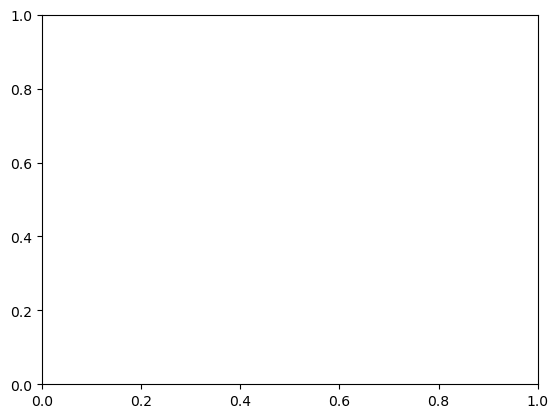

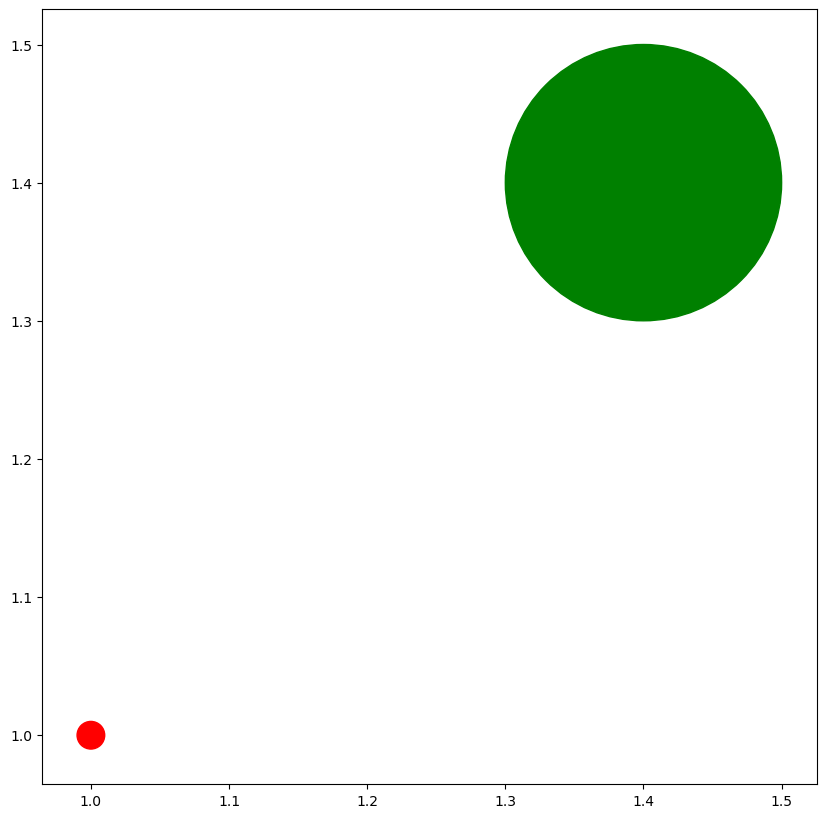

In [64]:
circle = plt.Circle((1.4,1.4), radius = 0.1, color = 'green')
circle2 = plt.Circle((1,1),radius= 0.01, color = 'red')

ax = plt.gca()
fig, ax = plt.subplots(figsize=(10, 30))
ax.add_patch(circle)
ax.add_patch(circle2)
ax.axis('scaled')
plt.show()

In [67]:
import pygame

# инициализиране на Pygame
pygame.init()

# създаване на прозорец
screen = pygame.display.set_mode((640, 480))

# изчакване на затварянето на прозореца
while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()

ModuleNotFoundError: No module named 'pygame'